In [1]:
import sys
sys.path.append("C:/Anaconda3/envs/cs4300/Lib/site-packages")
import csv
from collections import defaultdict
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline
import json
import math

In [135]:
from empath import Empath
import numpy as np
from scipy.stats import entropy
import string
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer as wnl
from nltk.tokenize import RegexpTokenizer
from stemming.porter2 import stem
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import re
with open('contractions.json','r') as con:
    contractions_dict=json.load(con)
with open('fake_quotes.json') as data_file:    
    fake_quotes = json.load(data_file)

In [146]:
#Construct a Tokenizer that deals with contractions 
regtokenizer =RegexpTokenizer("[a-z]+\'?")
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
lexicon = Empath()
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)

class LemmaTokenizer(object):
    def __init__(self):
            self.wnl = stem
    def __call__(self, doc,stemming=True):
        #stemming is a boolean value indicating if the results need to be stemmed
        if stemming==True:
            return [stem(t) for t in regtokenizer.tokenize(expand_contractions(doc.lower()))]
        else:
            return [t for t in regtokenizer.tokenize(expand_contractions(doc.lower()))]

In [85]:
#Construct Index 
author_to_ID=defaultdict(list)
ID_to_author=defaultdict(str)
ID_to_quote=defaultdict(str)
with open('quotes.csv','rb') as f:
    reader=csv.reader(f)
    for row in reader:
        ID_to_quote[int(row[0])]=row[2]
        ID_to_author[int(row[0])]=row[1]
        author_to_ID[(row[1])].append(row[0])

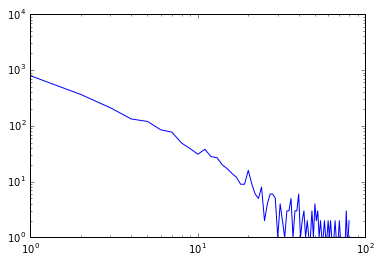

In [89]:
#hmm..power law
plt.loglog(Counter([len(item) for item in author_to_ID.values()]).values())

# Base-line Information Retrieval: Cosine Similarity

In [90]:
n_feats=5000;#Assuming the word usages are not more diverse than the movie scripts
tfidf_vec = TfidfVectorizer('content',tokenizer=LemmaTokenizer(),min_df=5,max_df=0.8,max_features=n_feats,norm=None )
doc_by_vocab=tfidf_vec.fit_transform([quote for quote in ID_to_quote.values()])

In [91]:
# Construct a inverted map from feature index to feature value (word) for later use
index_to_vocab = {i:v for i, v in enumerate(tfidf_vec.get_feature_names())}
vocab_to_index={v:i for i,v in enumerate(tfidf_vec.get_feature_names())}

In [92]:
np.size(doc_by_vocab,0)

21814

In [93]:
len(tfidf_vec.get_feature_names())

5000

In [94]:
doc_by_vocab = doc_by_vocab.toarray()

In [95]:
valid_type=tfidf_vec.get_feature_names()

In [96]:
def build_inverted_index(msgs):
    index= defaultdict(list)
    for i, msg in enumerate(msgs):
        all_toks=list(set(regtokenizer.tokenize(expand_contractions(msg))))
        for tok in all_toks:
            try:
                j=vocab_to_index[tok]
                index[tok].append((i+1,doc_by_vocab[i,j]))
            except KeyError:
                continue
            except IndexError:
                print(j)
    return index
pass

In [97]:
inD=build_inverted_index(ID_to_quote.values())

In [98]:

def compute_idf(inv_idx, n_docs):
    idf={}
    all_words=inv_idx.keys()
    for word in all_words:
        idf[word]=math.log(n_docs*1.0/(1+len(inv_idx[word])))
    return idf
    pass

In [99]:
idf=compute_idf(inD,len(ID_to_quote.values()))

In [100]:
def compute_doc_norms(index,n_docs):
    norms=np.zeros(n_docs)
    all_words=index.keys()
    for word in all_words:
        doc_idx=index[word]
        for docID,tfidf in doc_idx:
            norms[docID-1]=norms[docID-1]+(tfidf)**2
    norms=np.sqrt(norms)
    return norms
    pass

In [101]:
docnorms= compute_doc_norms(inD,len(ID_to_quote.values()))

In [102]:
#Build the base system of the information retrieval using cosine similarity
def baseIR(query):
    query=query.lower()
    query_modified=[stem(t) for t in regtokenizer.tokenize(expand_contractions(query)) if stem(t) in inD.keys()]
    qCounter=Counter(query_modified)
    score=defaultdict(float)
    qtfidf=[]
    for w in query_modified:
        qtfidf.append(qCounter[w]*idf[w])
    qnorm=np.sqrt(sum(np.array(qtfidf)**2))
    results= []
    for qword in qCounter.keys():
        all_docs= inD[qword]
        for docID,tfidf in all_docs:
            score[docID-1]+=tfidf*qCounter[qword]*idf[qword]/(1.0*(docnorms[docID-1]*qnorm))
    for dID in ID_to_quote.keys():
        results.append((score[dID-1],ID_to_quote[dID],dID-1)) 
    results.sort(key=lambda x: x[0],reverse=True)
    return query_modified,results

In [243]:
query,results= baseIR('It has been a tough day')

In [244]:
results[:10]

[(0.3918174686653948,
  "If you haven't found something strange during the day, it hasn't been much of a day.",
  21741),
 (0.36332163054507383,
  'A tough lesson in life that one has to learn is that not everybody wishes you well.',
  16855),
 (0.36270828062854549,
  "Cynicism is not realistic and tough. It's unrealistic and kind of cowardly because it means you don't have to try.",
  16125),
 (0.361495494485085,
  'Human kindness has never weakened the stamina or softened the fiber of a free people. A nation does not have to be cruel to be tough.',
  17068),
 (0.33988683985427687,
  "Life's a tough proposition, and the first hundred years are the hardest.",
  15730),
 (0.33780276161657358,
  'We must combine the toughness of the serpent and the softness of the dove, a tough mind and a tender heart.',
  2571),
 (0.32719136486503791,
  'Wait until it is night before saying that is has been a fine day.',
  4394),
 (0.3251229744246989,
  "It's not what you do once in a while, it's what y

# LDA: Topic Modeling

In [229]:
from sklearn import cross_validation
from sklearn.metrics import accuracy_score
from sklearn.metrics import mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [230]:
cv = TfidfVectorizer(tokenizer=LemmaTokenizer(),stop_words='english', max_df=.9,min_df=10**(-6),
                     max_features=5000)
counts = cv.fit_transform([quote for quote in ID_to_quote.values()])
feature_names = cv.get_feature_names()

In [231]:
n_topic = 20
model = LDA(n_topics=n_topic, max_iter=10, n_jobs=1, verbose=0)
res = model.fit_transform(counts)

In [232]:
def categorize_top_words(model, feature_names, n_top_words):
    result=[]
    for topic_idx, topic in enumerate(model.components_):
        st=" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        result.append(st)
    return result

In [1]:
def TMRetrieval(s,rank,similarity_measure=entropy,reverse=-1):
    query = cv.transform(s)
    unnormalized = np.matrix(model.transform(query))
    normalized=unnormalized/unnormalized.sum(axis =1)

    all_scores = []
    for i,data in enumerate(res):
        all_scores.append(similarity_measure(np.asarray(data).reshape(-1),np.asarray(normalized).reshape(-1)))
    

    top20=np.asarray(all_scores).argsort()[reverse*rank:]
    print("\n")
    for index in top20:
        print (ID_to_quote[index+1],ID_to_author[index+1],'similarity: ',all_scores[index])
        print ('\n')
    return top20

NameError: name 'entropy' is not defined

In [240]:
topindex=TMRetrieval(['It has been a tough day'],20)



('One man may hit the mark, another blunder but heed not these distinctions. Only from the alliance of the one, working with and through the other, are great things born.', 'Antoine De Saint-Exupery', 'similarity: ', 4.7161735501787216)


('I always like to know everything about my new friends, and nothing about my old ones.', 'Oscar Wilde', 'similarity: ', 4.7189334895869148)


('Always begin anew with the day, just as nature does it is one of the sensible things that nature does.', 'George E. Woodbury', 'similarity: ', 4.723085960958044)


('I report to you that our country is challenged at home and abroad that it is our will that is being tried and not our strength our sense of purpose and not our ability to achieve a better America.', 'Lyndon B. Johnson', 'similarity: ', 4.7269979444795398)


("I never lecture, not because I am shy or a bad speaker, but simply because I detest the sort of people who go to lectures and don't want to meet them.", 'H.L. Mencken', 'similarity: ', 4.7

array([  351,  5130, 19217,   227,    30,   576,   149,   127,   237,
        9973,   102,   500,     5,  7078,   411,   253, 20359,   107,
        2550,   152], dtype=int64)

# Aggregating Author's quote (NOT RECOMMENDED)

In [210]:
newquotes=defaultdict(str)
for author in author_to_ID.keys():
    for quoteID in author_to_ID[author]:
        newquotes[author]=newquotes[author]+'/*/'+ID_to_quote[int(quoteID)]

In [215]:
n_feats=5000;#Assuming the word usages are not more diverse than the movie scripts
agg_model = TfidfVectorizer('content',tokenizer=LemmaTokenizer(),min_df=10**(-6),max_df=0.8,max_features=n_feats,norm=None )
agg_matrix=agg_model.fit_transform([quote for quote in newquotes.values()])


agg_cv = CountVectorizer(tokenizer=LemmaTokenizer(), max_df=.8,min_df=10**(-6),max_features=5000)
agg_counts = agg_cv.fit_transform([quote for quote in newquotes.values()])

n_topic = 20

model_agg = LDA(n_topics=n_topic, max_iter=10, n_jobs=1, verbose=0)
agg = model_agg.fit_transform(agg_counts)


In [227]:
def AggIR(s,numRetrieve,rank=3, similarity_measure=entropy, reverse=-1,selection='mean'):
    query = agg_model.transform(s)
    unnormalized = np.matrix(model_agg.transform(query))
    normalized=unnormalized/unnormalized.sum(axis =1)
    #Naively, we are using the average quality of the aggregated_quote to measure similarity
    #Other ways could be using the modes of the aggregation
    if selection=='mean':
        all_scores = []
        for i,data in enumerate(agg):
            all_scores.append(similarity_measure(np.asarray(data).reshape(-1),np.asarray(normalized).reshape(-1)))
    else:
        print('error')
    top20=np.asarray(all_scores).argsort()[reverse*rank:]

    
    print("\n")
    for index in top20:
        print (newquotes[ID_to_author[index+1]],all_scores[index])
        print ('\n')
    return top20

In [228]:
AggIR(['It has been a tough day'],10)



("/*/The object of the superior man is truth./*/A journey of a thousand miles begins with a single step./*/I hear and I forget. I see and I remember. I do and I understand./*/Only the wisest and stupidest of men never change./*/Our greatest glory is not in never falling, but in rising every time we fall./*/Real knowledge is to know the extent of one's ignorance./*/A man who does not plan long ahead will find trouble right at his door./*/Everything has its beauty but not everyone sees it./*/To know that one knows what one knows, and to know that one doesn't know what one doesn't know, there lies true wisdom./*/Without knowing the force of words, it is impossible to know men./*/Things that are done, it is needless to speak about...things that are past, it is needless to blame./*/The cautious seldom err./*/He who wishes to secure the good of others has already secured his own./*/To be wronged is nothing unless you continue to remember it./*/Learning without thought is labor lost thought

array([1225,  222,   24], dtype=int64)

# Create Fake Documents

In [142]:
#Expand every word in the document by Stanford Empath Library
def fake_words(w,span):
    fiction_set=lexicon.create_category(w,[w],size=span,model='fiction',write=False)
    nytimes_set=lexicon.create_category(w,[w],size=span,model='nytimes',write=False)
    reddit_set=lexicon.create_category(w,[w],size=span,model='reddit',write=False)
    results = set((set(nytimes_set).intersection(set(reddit_set))).union((set(fiction_set).intersection(set(nytimes_set)))))
    return list(results)

In [143]:
def add_fake_words(w,span):
    ws=" ".join(fake_words(w,span))
    return ws

In [57]:
import collections
#Read the fake documents
with open('fake_documents.json','r') as data:
    fake_documents= json.load(data)
fake_documents=collections.OrderedDict(sorted(fake_documents.items(),key=lambda t:int(t[0])))

In [235]:
n_feats=5000;#Assuming the word usages are not more diverse than the movie scripts
fake_model = TfidfVectorizer('content',tokenizer=LemmaTokenizer(),min_df=5,max_df=0.8,max_features=n_feats,norm=None )
fake_matrix=fake_model.fit_transform([quote for quote in fake_documents.values()])

In [236]:
#Construct the training matrix
fake_cv = CountVectorizer(tokenizer=LemmaTokenizer(), max_df=.9,min_df=10**(-6),
                     max_features=5000)
fake_counts = fake_cv.fit_transform([quote for quote in fake_documents.values()])
#Number of topics
n_topic = 20
#Outline the structure of the model
model1 = LDA(n_topics=n_topic, max_iter=10, n_jobs=1, verbose=0)
#Fit the model
res1 = model1.fit_transform(fake_counts)


In [241]:
def FakeIR(s,rank, similarity_measure=entropy, reverse=-1):
    query = fake_model.transform(s)
    unnormalized = np.matrix(model1.transform(query))
    normalized=unnormalized/unnormalized.sum(axis =1)

    all_scores = []
    for i,data in enumerate(res1):
        all_scores.append(similarity_measure(np.asarray(data).reshape(-1),np.asarray(normalized).reshape(-1)))
    

    top20=np.asarray(all_scores).argsort()[reverse*rank:]
    print("\n")
    for index in top20:
        print (ID_to_quote[index+1],ID_to_author[index+1],all_scores[index])
        print ('\n')
    return top20

In [242]:
topindex=FakeIR(['It has been a tough day.'],20)



("To be pleased with one's limits is a wretched state.", 'Johann Wolfgang von Goethe', 5.4861491545679373)


('Against logic there is no armor like ignorance.', 'Laurence J. Peter', 5.4864785279914212)


('Truth is the summit of being justice is the application of it to affairs.', 'Ralph Waldo Emerson', 5.4952897680363328)


('When you have nothing to say, say nothing.', 'Charles Caleb Colton', 5.4952897696361598)


('Excuse me while I kiss the sky.', 'Jimi Hendrix', 5.5038257572705929)


('Let the refining and improving of your own life keep you so busy that you have little time to criticize others.', 'H. Jackson Browne', 5.5038257596702742)


('The golden rule is that there are no golden rules.', 'George Bernard Shaw', 5.5118163328392402)


('If an eye never falls asleep, All dreams will by themselves cease If the mind retains its absoluteness, The ten thousand things are of one suchness.', "Seng-T'San", 5.5193131620577622)


('Nothing is there more friendly to a man than a friend 

array([20328,  3630,   594,  2315, 14113, 11320,   469, 17444, 21025,
          33, 12566, 15263, 17386, 12101, 19907,   166, 10740, 10126,
        9198, 13069], dtype=int64)

# --------------------------IGNORE CELLS BELOW THIS ONE---------------------------------

# Tackle the problem from PLS and Group LASSO

# Biterm Model

# Additional features: pronounces, mark of negation, diverse of speech?sentimental analysis?

In [ ]:
lexicon.create_category('people',['people'],size=20,model='reddit',write=False)

In [ ]:
lexicon.create_category('people',['people'],size=20,model='nytimes',write=False)

In [ ]:
lexicon.create_category('people',['people'],size=20,model='fiction',write=False)

In [ ]:
fake_words('him',20)

In [133]:
(2,1) in set([(1,2),(3,4)])

False

In [172]:
s=['it has been a tough day']
query = tfidf_vec.transform(s)
unnormalized = np.matrix(model.transform(query))
normalized=unnormalized/unnormalized.sum(axis =1)

In [173]:
np.size(unnormalized)

20

In [174]:
len(unnormalized)

1

In [175]:
np.size(res)

436200

In [170]:
len(unnormalized)

23

In [171]:
len(s)

23